In [110]:
import os
from math import pi
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import ProbDistribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime.fake_provider import FakeValenciaV2
from qiskit_ibm_runtime import SamplerV2

import matplotlib.pyplot as plt

from utils import export_data_json, generate_output_dir, generate_full_file_path

In [2]:
OUTPUT_PATH = os.path.join(os.getcwd(), 'dynamic-circuit-tests')
generate_output_dir(OUTPUT_PATH)

Creating folder: /home/alexandre/projects/scientific-research-2-qec-and-qem/src/dynamic-circuit-tests


In [27]:
fake_backend = FakeValenciaV2()
backend = AerSimulator.from_backend(fake_backend)

In [4]:
sampler = SamplerV2(backend=backend)

In [73]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

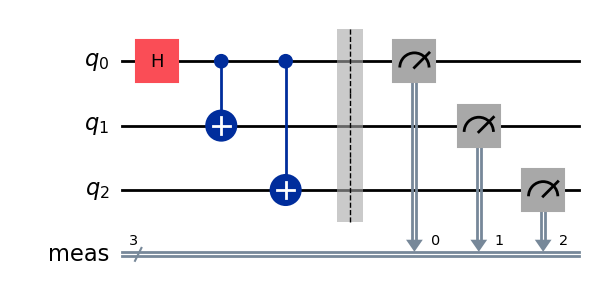

Default Circuit DEPTH: 4


In [76]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
qc.measure_all()
display(qc.draw('mpl', filename=generate_full_file_path(OUTPUT_PATH, "GHZ-circuit.png")))
print(f"Default Circuit DEPTH: {qc.depth()}")

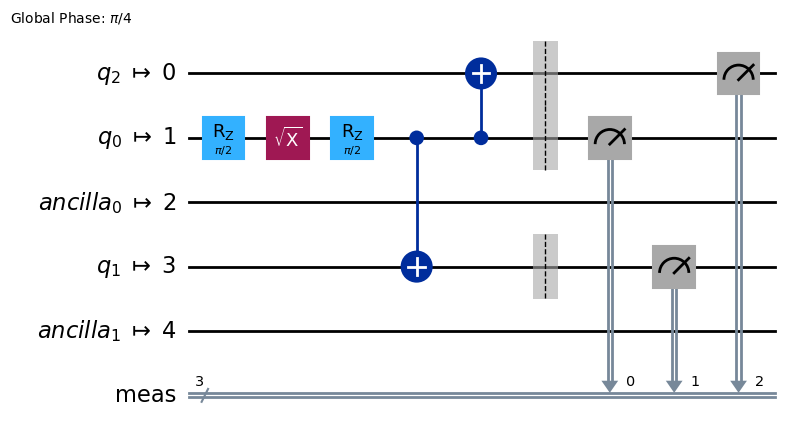

ISA Circuit DEPTH: 6


In [77]:
isa_circuit = pm.run(qc)
display(isa_circuit.draw('mpl', idle_wires=True, filename=generate_full_file_path(OUTPUT_PATH, "ISA-GHZ-circuit.png")))
print(f"ISA Circuit DEPTH: {isa_circuit.depth()}")

In [78]:
SHOTS = 1000

In [79]:
isa_circuit_cp = isa_circuit.copy()
isa_circuit_cp.measure_all()
results = sampler.run([isa_circuit_cp], shots=SHOTS).result()[0]

In [99]:
counts = results.data.meas.get_counts()
print(counts)
export_data_json(counts, generate_full_file_path(OUTPUT_PATH, "noisy-outputs.json"))

{'000': 408, '111': 441, '001': 20, '010': 32, '110': 17, '101': 28, '100': 32, '011': 22}
saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/dynamic-circuit-tests/noisy-outputs.json...


In [81]:
quasi = ProbDistribution(counts).binary_probabilities(num_bits=N_QUBITS)

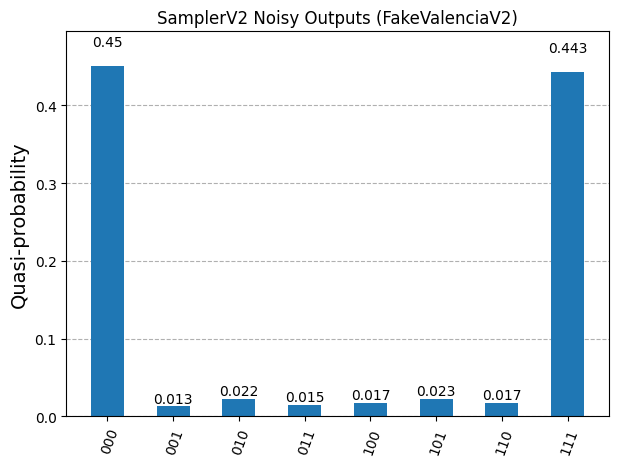

In [82]:
fig = plot_distribution(quasi, title="SamplerV2 Noisy Outputs (FakeValenciaV2)")
fig.savefig(generate_full_file_path(OUTPUT_PATH, "sampler-noisy-ouputs.png"))
display(fig)

---

In [83]:
qubits = QuantumRegister(backend.num_qubits, name="q")
mid_meas = ClassicalRegister(N_QUBITS, name="mid")
final_meas = ClassicalRegister(N_QUBITS, name="meas")

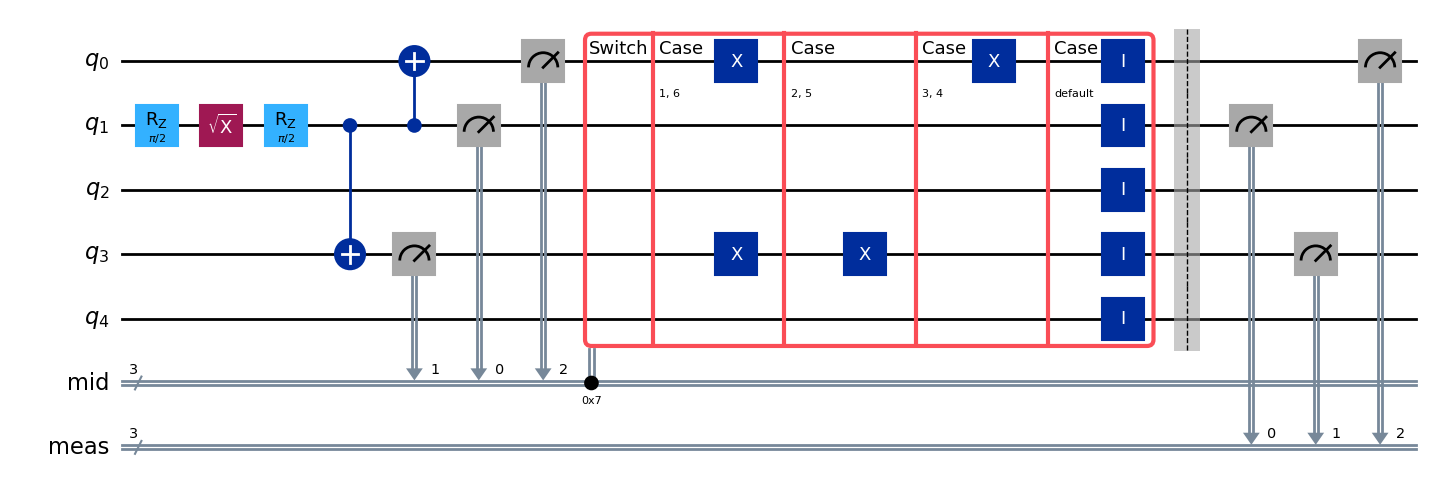

Default Circuit DEPTH: 8


In [100]:
qc = QuantumCircuit(qubits, mid_meas, final_meas)
#qc.h(qubits[0])
qc.rz(pi/2, 1)
qc.sx(1)
qc.rz(pi/2, 1)
qc.cx(qubits[1], qubits[3])
qc.cx(qubits[1], qubits[0])

qc.measure([1,3,0], mid_meas)

with qc.switch(mid_meas) as case:
    with case(1,6): #001 and 110
        qc.x([qubits[3], qubits[0]])

    with case(2,5): #010 and 101
        qc.x(qubits[3])

    with case(3,4): #011 and 100
        qc.x(qubits[0])
    
    with case(case.DEFAULT): #000 and 111
        qc.id(qubits)

qc.barrier()
qc.measure([1,3,0], final_meas)

display(qc.draw('mpl', filename=generate_full_file_path(OUTPUT_PATH, "GHZ-dynamic-circuit.png")))
print(f"Default Circuit DEPTH: {qc.depth()}")

In [131]:
results = fake_backend.run(qc).result().get_counts()

In [132]:
syndromes = {
    '000':'000', 
    '001':'111',
    '010':'000',
    '011':'111',
    '100':'000',
    '101':'111',
    '110':'000',
    '111':'111'
}

In [135]:
parsed_results = defaultdict(int)
for k,v in results.items():
    bit_strings = k.split()
    if(syndromes[bit_strings[-1]] == bit_strings[0]):
        parsed_results[bit_strings[0]] += v
    else:
        parsed_results['-'] += v

In [136]:
dist = {}
for k,v in parsed_results.items():
    dist[k] = v/SHOTS

In [137]:
export_data_json(dist, generate_full_file_path(OUTPUT_PATH, "corrected-outputs.json"))

saving /home/alexandre/projects/scientific-research-2-qec-and-qem/src/dynamic-circuit-tests/corrected-outputs.json...


In [150]:
print(dist)

{'-': 0.163, '000': 0.485, '111': 0.376}


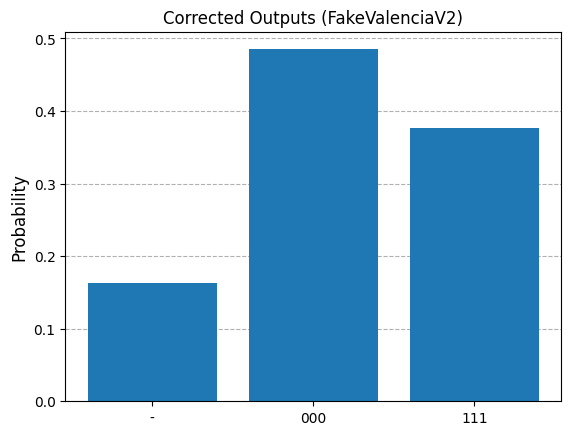

In [149]:
plt.bar(x=list(dist.keys()), height=list(dist.values()))
plt.grid(which='major',linestyle='--',axis='y', zorder=-1.0)
plt.title("Corrected Outputs (FakeValenciaV2)")
plt.ylabel("Probability",fontsize=12)
plt.show()
#fig.savefig(generate_full_file_path(OUTPUT_PATH, "sampler-corrected-ouputs.png"))
